In [1]:
#! python2
# -*- coding: utf-8 -*-
import pprint
import pymongo
import datetime
import numpy as np
from pymongo import MongoClient

from scipy import spatial

import pylab

import os
import progressbar

db_name = 'twitter'
col_name = 'replab'

In [2]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity

from igraph import *
import igraph
import math
from operator import itemgetter



In [3]:
class MyPrettyPrinter(pprint.PrettyPrinter):
    def format(self, object, context, maxlevels, level):
        if isinstance(object, unicode):
            return (object.encode('thai'), True, False)
        return pprint.PrettyPrinter.format(self, object, context, maxlevels, level)

def go_print( input ):
    MyPrettyPrinter().pprint(input)
    # ppp = pprint.PrettyPrinter(indent=4)
    # ppp.pprint(input)
    return;

def get_midnight(time):
    return time.replace(minute=0, hour=0, second=0, microsecond=0)

def get_time_gap(time,hour_gap=1,min_gap=1):
    h = time.hour
    m = time.minute
    o_h = h/hour_gap*hour_gap
    o_m = m/min_gap*min_gap
    return time.replace(hour=o_h, minute=o_m, second=0, microsecond=0)

def get_week_year(time):
    return tuple([time.isocalendar()[0], time.isocalendar()[1]])

def get_thai_midnight(time):
    out = time + datetime.timedelta(hours=7)
    out = out.replace(minute=0, hour=0, second=0, microsecond=0) - datetime.timedelta(hours=7)
    return out

In [4]:
if __name__ == '__main__':
    client = MongoClient()
    db = client[db_name]

    result = db[col_name].create_index([('ts', pymongo.ASCENDING)])
    cursor = db[col_name].find({'ts':{'$gte':1338508800}}).sort([('ts', pymongo.ASCENDING)])
    

    entity = {}
    count = {}
    count_wk = {}
    
    topic_per_time = {}

    bar = progressbar.ProgressBar(maxval=cursor.count()+1, widgets=[progressbar.Bar('#', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    data=1
    for doc in cursor:
        data += 1
        bar.update(data)
        
        ts = doc['ts']
        entity_id = doc['entity_id']
        topic = doc['topic']
        datetime_object = datetime.datetime.fromtimestamp(ts)
        time_gap = get_midnight(datetime_object)
        
        if not entity.has_key(entity_id):
            entity[entity_id] = {}
        if not entity[entity_id].has_key(topic):
            entity[entity_id][topic] = {}
        if not time_gap in entity[entity_id][topic]:
            entity[entity_id][topic][time_gap] = 0
        entity[entity_id][topic][time_gap] += 1
        
        if not topic_per_time.has_key(time_gap):
            topic_per_time[time_gap] = {}
        if not topic_per_time[time_gap].has_key(topic):
             topic_per_time[time_gap][topic] = 0
        topic_per_time[time_gap][topic] += 1
        
        time_gap = get_midnight(datetime_object) 
        if not count.has_key(time_gap):
            count[time_gap] = 0
        count[time_gap] += 1
        
        time_gap = get_week_year(datetime_object) 
        if not count_wk.has_key(time_gap):
            count_wk[time_gap] = 0
        count_wk[time_gap] += 1
        
        
        
    bar.finish()
#     print len(date)

[########################################################################] 100%


In [5]:
print 'avg per day\t: ',sum(count.values())/len(count)
print 'avg per week\t: ',sum(count_wk.values())/len(count_wk)

print 'max per day\t: ',max(count.values())
print 'max per week\t: ',max(count_wk.values())

avg per day	:  375
avg per week	:  2509
max per day	:  2341
max per week	:  11828


In [7]:
test_data = []
for day, topic_count in topic_per_time.items():
    for v in topic_count.values():
        test_data.append(v)

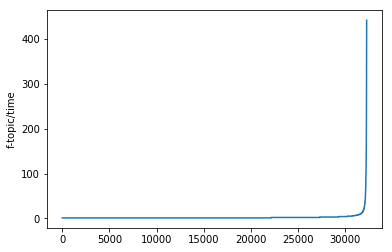

2
Counter({1: 22153, 2: 5166, 3: 1975, 4: 950, 5: 539, 6: 308, 7: 230, 8: 164, 9: 102, 10: 91, 11: 61, 12: 46, 14: 42, 13: 40, 15: 29, 18: 28, 17: 20, 20: 19, 19: 17, 16: 16, 21: 16, 23: 13, 25: 10, 29: 9, 30: 9, 22: 8, 26: 7, 28: 7, 37: 7, 24: 6, 33: 6, 34: 6, 35: 6, 38: 6, 27: 5, 40: 5, 31: 4, 36: 4, 39: 4, 46: 4, 48: 4, 51: 4, 63: 4, 74: 4, 92: 4, 32: 3, 45: 3, 49: 3, 52: 3, 57: 3, 67: 3, 41: 2, 43: 2, 44: 2, 50: 2, 53: 2, 54: 2, 55: 2, 60: 2, 62: 2, 68: 2, 71: 2, 73: 2, 75: 2, 77: 2, 84: 2, 85: 2, 88: 2, 100: 2, 102: 2, 105: 2, 120: 2, 133: 2, 159: 2, 179: 2, 361: 2, 42: 1, 47: 1, 61: 1, 64: 1, 65: 1, 69: 1, 72: 1, 78: 1, 79: 1, 82: 1, 90: 1, 97: 1, 99: 1, 107: 1, 112: 1, 115: 1, 119: 1, 126: 1, 130: 1, 131: 1, 132: 1, 134: 1, 138: 1, 139: 1, 142: 1, 143: 1, 146: 1, 148: 1, 149: 1, 156: 1, 158: 1, 162: 1, 172: 1, 176: 1, 181: 1, 182: 1, 191: 1, 193: 1, 198: 1, 206: 1, 222: 1, 225: 1, 228: 1, 232: 1, 240: 1, 242: 1, 262: 1, 270: 1, 284: 1, 293: 1, 314: 1, 328: 1, 331: 1, 337: 1, 340

In [10]:
import matplotlib.pyplot as plt
plt.plot(sorted(test_data))
plt.ylabel('f-topic/time')
plt.show()
print (sum(test_data)/len(test_data))
from collections import Counter
print Counter(test_data)

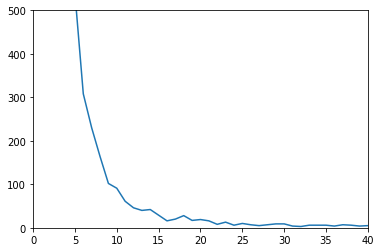

In [17]:
dt = Counter(test_data)
plt.plot(dt.keys(),dt.values())
plt.axis([0, 40, 0, 500])
plt.show()

In [ ]:

ts = 1353459600
ts = 1349689576
datetime_o = datetime.datetime.fromtimestamp(ts)
print get_midnight(datetime_o)
for k,v in topic_per_time[get_midnight(datetime_o)].items():
    if v>=3:
        print k,v

In [ ]:
for day,num in sorted(count.items() ):
    print day,num

In [ ]:
for time,topic_set in sorted(topic_per_time.items()):
    print topic_set

In [ ]:
for k,v in entity.items():
#     print k,len(v)
    print '\n\n\n++++++'
    for topic,time in v.items():
#         if len(time) > 5 and topic != '':
#         if topic != '':
        if sum(time.values()) > 10 and max(time.values()) >= 3 and topic != '':
            print topic,time.values()

In [ ]:
for k,v in entity.items():
#     print k,len(v)
    print '\n\n\n++++++'
    for topic,time in v.items():
#         if len(time) > 5 and topic != '':
#         if topic != '':
        if topic == "Gossip: JL and her kids":
            print time